## **Pré-Processamento Pós EDA**
* Conversando com a Fernanda percebemos que nossa análise é sobre a partida então features de estatísticas gerais dos times não ou pouco importariam para o nosso clustering.
* Outra questão que percebemos também é que existem features do Time B que podem dizer comportamentos do time A (um time B com muitos erros pode indicar também um time A com alta Hit Pct). Então decidimos voltar atrás na retirada das colunas do time B
* Como times variam bastante de jogadores de um ano para o outro, decidimos diferenciar um time A de 2019 de um time A de 2018.
* para identificar isso iremos criar alguns ids como ID da Partida e ID do time naquele ano

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

In [11]:
df = pd.read_csv("C:/Users/gabri/OneDrive/Documents/Faculdade/2024.2/Projeto de Ciência de Dados/novo/volleyball-case-study/data/para-o-projeto/team_v_team.csv")
df.head()

,Unnamed: 0,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,...,Team B Hit Pct,Team B Assists,Team B Aces,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS
0,0,8302019,USC Upstate,Virginia Tech,0,4.0,33,21,112,0.107,...,0.234,48,13,12,51,4,4,20,2,0.0
1,1,8302019,USC Upstate,Northwestern,0,3.0,16,24,89,-0.090,...,0.349,41,6,7,42,1,2,20,0,0.0
2,2,9072019,USC Upstate,Ga. Southern,0,3.0,37,20,117,0.145,...,0.239,39,4,5,49,2,1,6,1,50.0
3,3,9132019,USC Upstate,Norfolk St.,1,5.0,50,27,164,0.140,...,0.114,47,11,15,67,9,1,17,1,70.5
4,4,9142019,USC Upstate,George Washington,0,3.0,30,17,112,0.116,...,0.216,44,3,1,60,2,1,6,6,52.0


In [12]:
def format_date(date):
    date_str = str(date)  # Converte o inteiro para string
    if len(date_str) == 7:  # Caso a data tenha 7 caracteres (mês ou dia com um único dígito)
        return pd.to_datetime(date_str, format='%m%d%Y')
    else:
        return pd.to_datetime(date_str, format='%m%d%Y')

# Aplicar a função de formatação às datas
df['Date'] = df['Date'].apply(format_date)
df = df.drop(columns=["Unnamed: 0"])

In [13]:
# Criando um dicionário para mapear os IDs dos times
team_ids = {team: idx for idx, team in enumerate(set(df["TeamA"]).union(df["TeamB"]))}

# Adicionando colunas de IDs de time
df["TeamA_ID"] = df["TeamA"].map(team_ids)
df["TeamB_ID"] = df["TeamB"].map(team_ids)

# Criando a coluna de ID da partida, garantindo que os jogos reversos tenham o mesmo ID
df["Match_ID"] = df.apply(lambda row: (row["Date"], tuple(sorted([row["TeamA_ID"], row["TeamB_ID"]]))), axis=1)

# Convertendo a combinação (data, time A ID, time B ID) em um identificador numérico único
df["Match_ID"] = df["Match_ID"].apply(lambda x: hash(x))

df.head()

df

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
0,2019-08-30,USC Upstate,Virginia Tech,0,4.0,33,21,112,0.107,30,...,12,51,4,4,20,2,0.0,113,71,-3143719273304911588
1,2019-08-30,USC Upstate,Northwestern,0,3.0,16,24,89,-0.090,15,...,7,42,1,2,20,0,0.0,113,67,-3288664811647239995
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,37,20,117,0.145,35,...,5,49,2,1,6,1,50.0,113,21,2505897241756808
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,50,27,164,0.140,47,...,15,67,9,1,17,1,70.5,113,295,-5714580449193892544
4,2019-09-14,USC Upstate,George Washington,0,3.0,30,17,112,0.116,30,...,1,60,2,1,6,6,52.0,113,119,-4561260656140183924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37645,2016-11-01,Elon,N.C. Central,1,3.0,52,14,106,0.358,50,...,4,33,4,1,6,5,32.0,239,73,-6590799823624615724
37646,2016-11-05,Elon,Col. of Charleston,0,3.0,39,21,125,0.144,35,...,4,61,7,2,8,4,55.0,239,287,6756990473158998285
37647,2016-11-07,Elon,UNCW,0,3.0,44,28,131,0.122,40,...,1,48,1,2,17,2,49.5,239,288,8622344295819897019
37648,2016-11-11,Elon,Hofstra,0,5.0,49,37,156,0.077,45,...,17,54,4,2,14,0,70.0,239,100,7358422482560396441


### **Verificando Distribuição dos Dados em Relação a Normal**

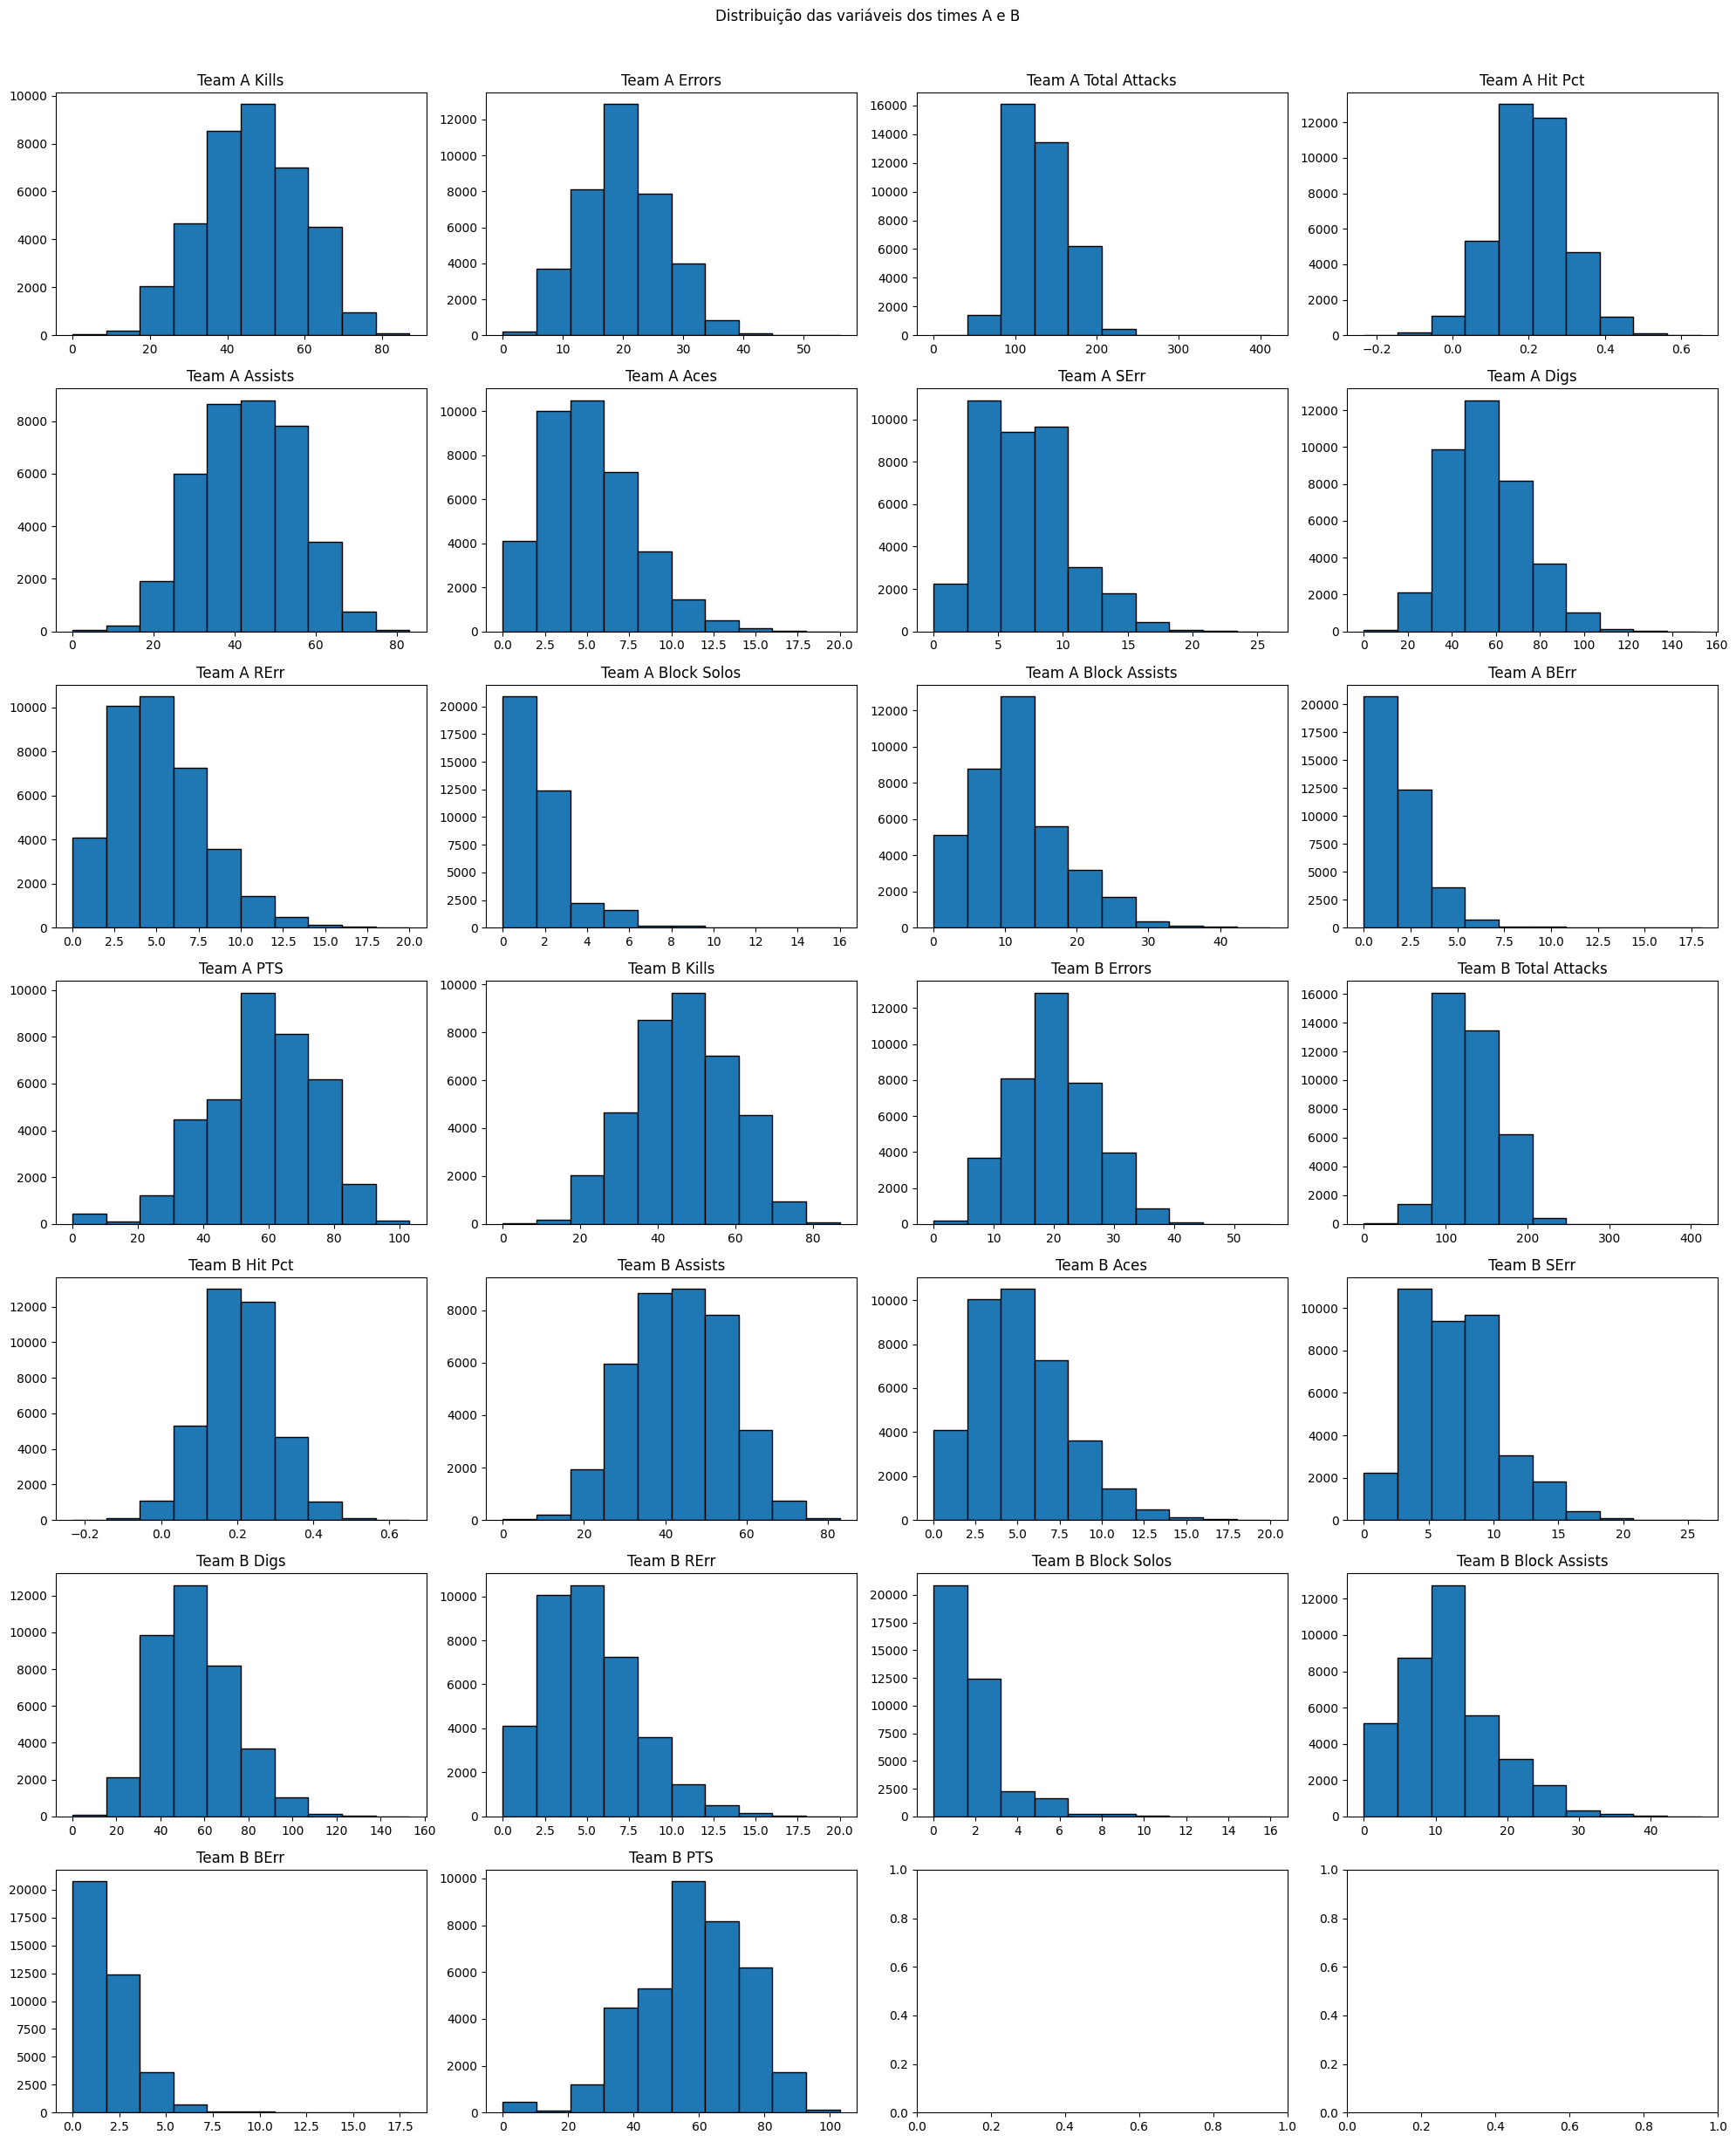

In [14]:
fig, axs = plt.subplots(7, 4, figsize=(20, 25))
fig.suptitle('Distribuição das variáveis dos times A e B')

colunas = df.columns

colunas_verify = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists', 'Team A Aces', 'Team A SErr', 'Team A Digs',
       'Team A RErr', 'Team A Block Solos', 'Team A Block Assists',
       'Team A BErr', 'Team A PTS', 'Team B Kills', 'Team B Errors',
       'Team B Total Attacks', 'Team B Hit Pct', 'Team B Assists',
       'Team B Aces', 'Team B SErr', 'Team B Digs', 'Team B RErr',
       'Team B Block Solos', 'Team B Block Assists', 'Team B BErr',
       'Team B PTS']

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    axs[i].hist(df[col], bins=10, edgecolor='black')
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [15]:
scaler = MinMaxScaler()
df_norm = df
df_norm[colunas_verify] = scaler.fit_transform(df[colunas_verify])
df_norm


,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
0,2019-08-30,USC Upstate,Virginia Tech,0,4.0,0.379310,0.375000,0.271845,0.384181,0.361446,...,0.461538,0.333333,0.20,0.2500,0.425532,0.111111,0.000000,113,71,-3143719273304911588
1,2019-08-30,USC Upstate,Northwestern,0,3.0,0.183908,0.428571,0.216019,0.161582,0.180723,...,0.269231,0.274510,0.05,0.1250,0.425532,0.000000,0.000000,113,67,-3288664811647239995
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.425287,0.357143,0.283981,0.427119,0.421687,...,0.192308,0.320261,0.10,0.0625,0.127660,0.055556,0.485437,113,21,2505897241756808
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.574713,0.482143,0.398058,0.421469,0.566265,...,0.576923,0.437908,0.45,0.0625,0.361702,0.055556,0.684466,113,295,-5714580449193892544
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.344828,0.303571,0.271845,0.394350,0.361446,...,0.038462,0.392157,0.10,0.0625,0.127660,0.333333,0.504854,113,119,-4561260656140183924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37645,2016-11-01,Elon,N.C. Central,1,3.0,0.597701,0.250000,0.257282,0.667797,0.602410,...,0.153846,0.215686,0.20,0.0625,0.127660,0.277778,0.310680,239,73,-6590799823624615724
37646,2016-11-05,Elon,Col. of Charleston,0,3.0,0.448276,0.375000,0.303398,0.425989,0.421687,...,0.153846,0.398693,0.35,0.1250,0.170213,0.222222,0.533981,239,287,6756990473158998285
37647,2016-11-07,Elon,UNCW,0,3.0,0.505747,0.500000,0.317961,0.401130,0.481928,...,0.038462,0.313725,0.05,0.1250,0.361702,0.111111,0.480583,239,288,8622344295819897019
37648,2016-11-11,Elon,Hofstra,0,5.0,0.563218,0.660714,0.378641,0.350282,0.542169,...,0.653846,0.352941,0.20,0.1250,0.297872,0.000000,0.679612,239,100,7358422482560396441


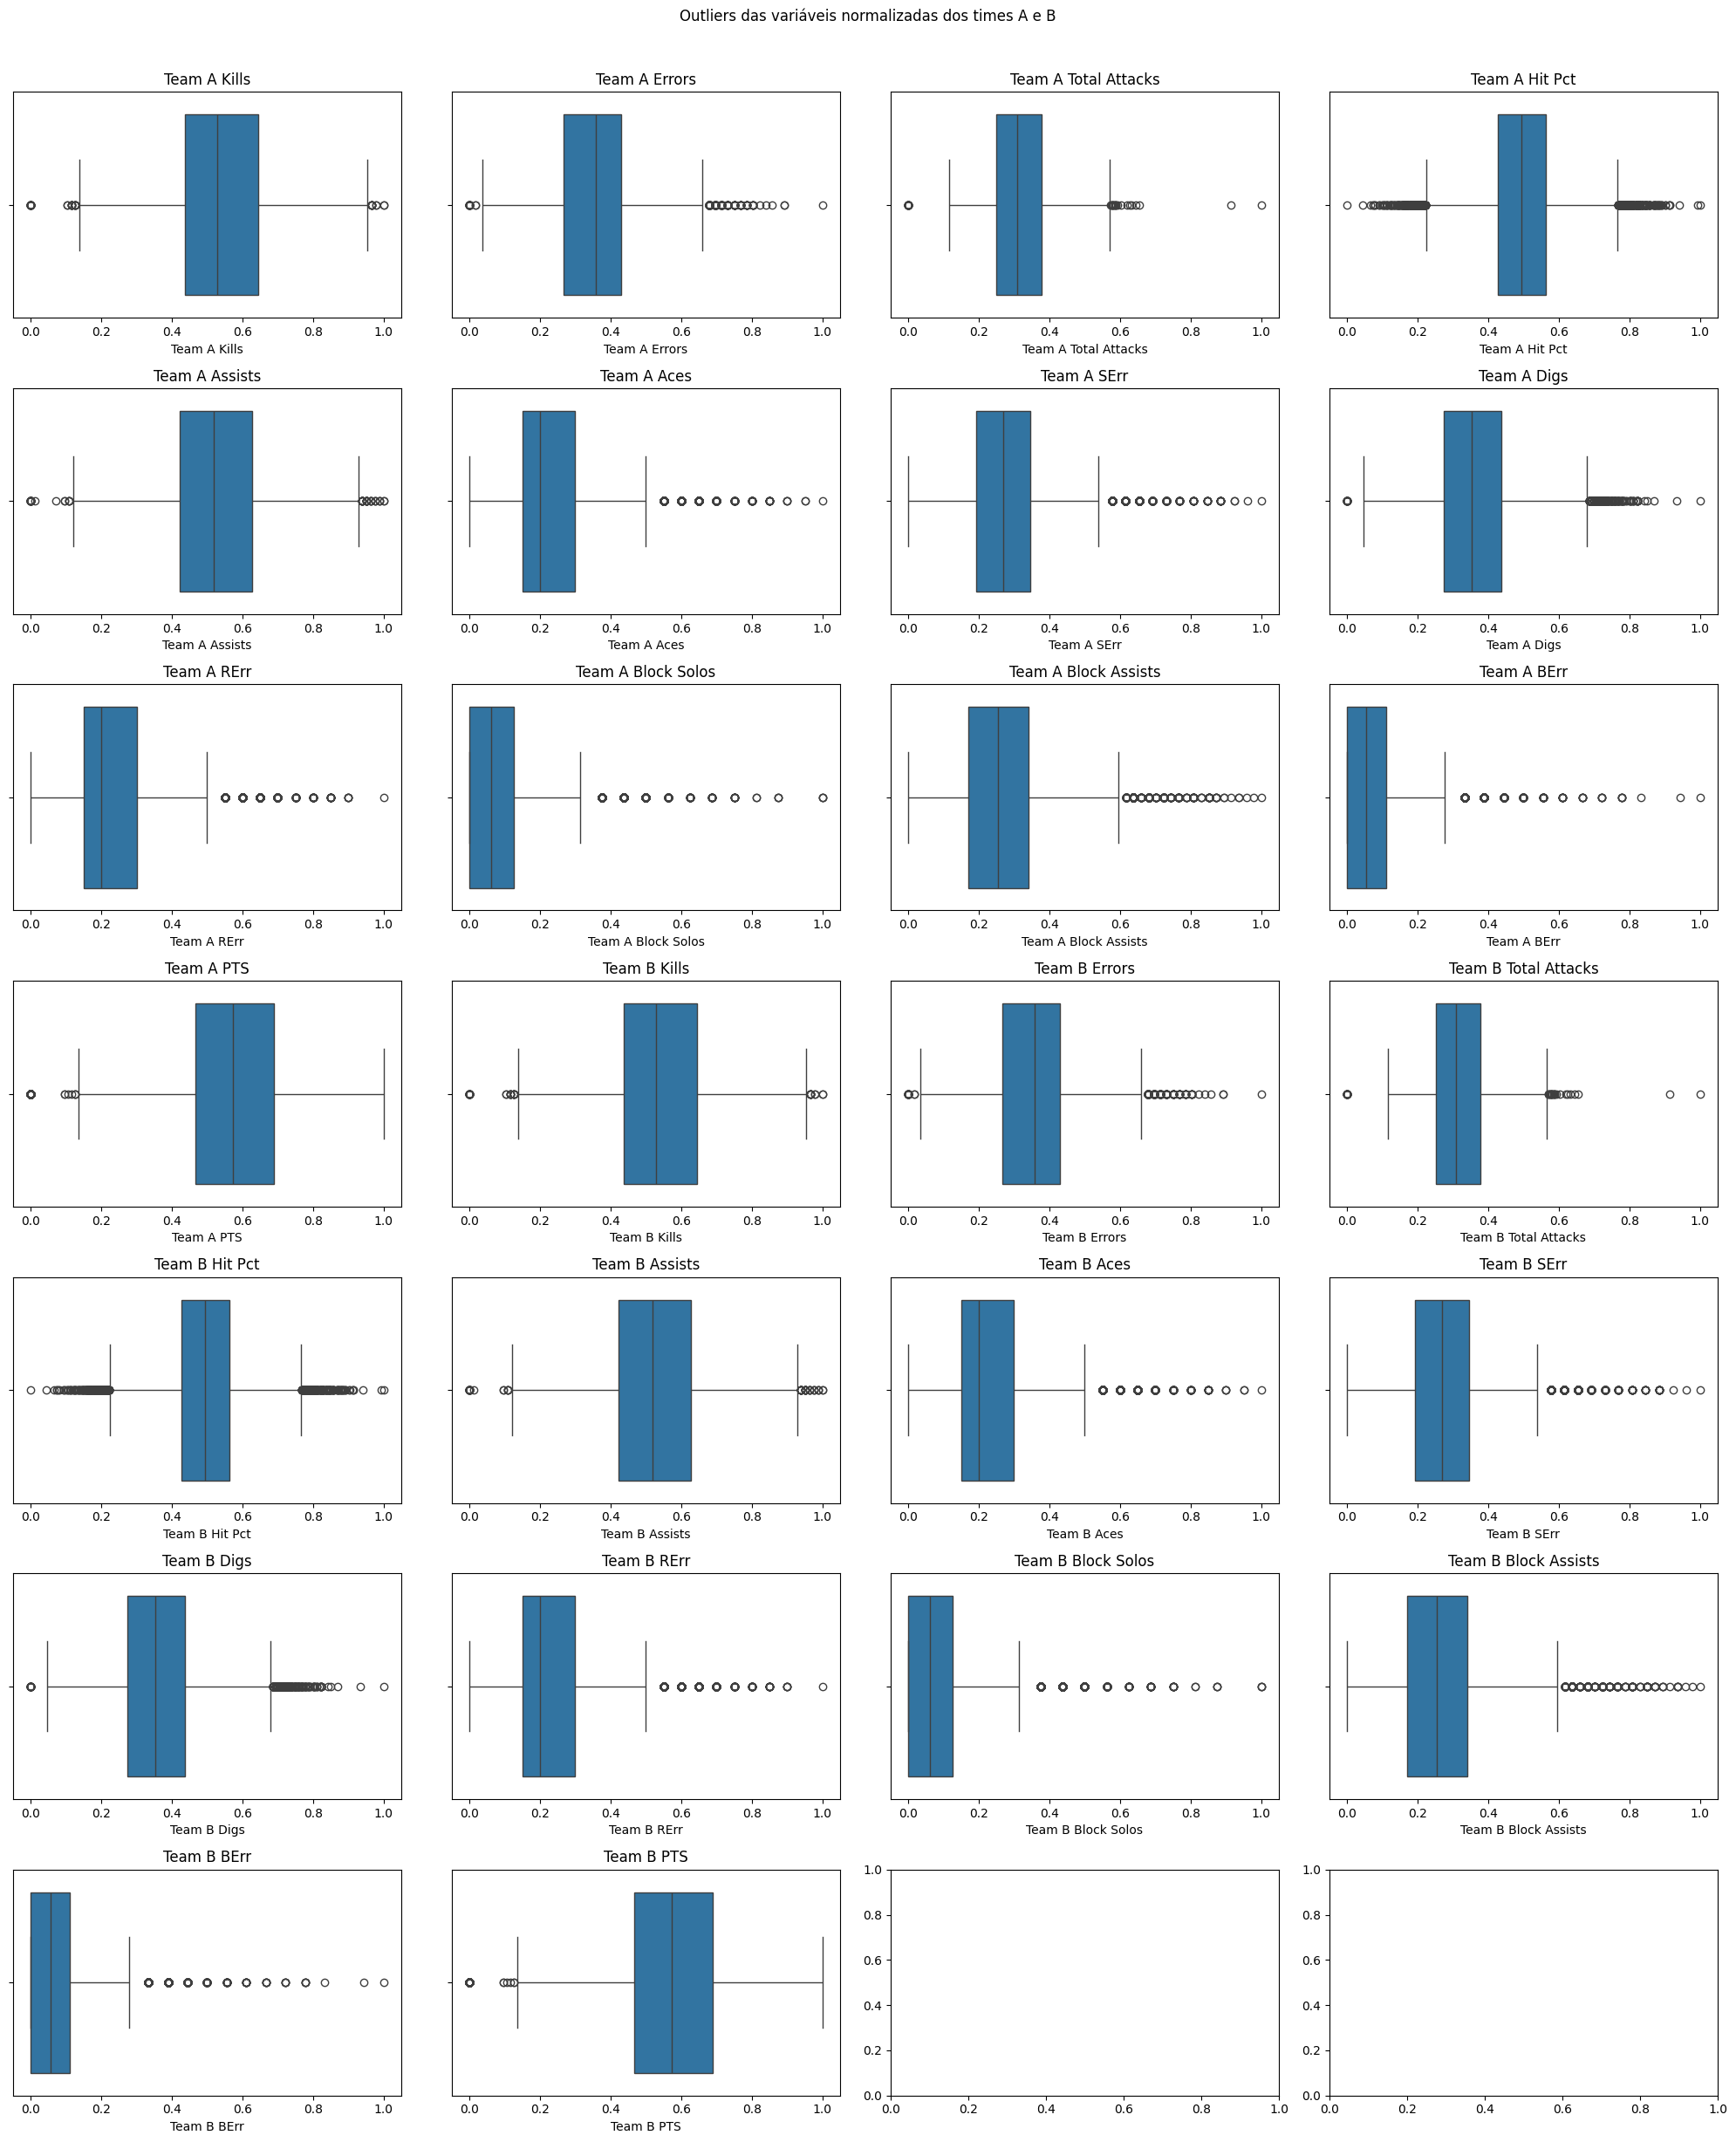

In [7]:
fig, axs = plt.subplots(7, 4, figsize=(20, 25))
fig.suptitle('Outliers das variáveis normalizadas dos times A e B')

axs = axs.ravel()

for i, col in enumerate(colunas_verify):
    sns.boxplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [16]:
from scipy import stats

z_scores = stats.zscore(df[colunas_verify])
df_norm_clean = df[(abs(z_scores) < 3).all(axis=1)]
df_norm_clean

,Date,TeamA,TeamB,Result,S,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct,Team A Assists,...,Team B SErr,Team B Digs,Team B RErr,Team B Block Solos,Team B Block Assists,Team B BErr,Team B PTS,TeamA_ID,TeamB_ID,Match_ID
2,2019-09-07,USC Upstate,Ga. Southern,0,3.0,0.425287,0.357143,0.283981,0.427119,0.421687,...,0.192308,0.320261,0.10,0.0625,0.127660,0.055556,0.485437,113,21,2505897241756808
3,2019-09-13,USC Upstate,Norfolk St.,1,5.0,0.574713,0.482143,0.398058,0.421469,0.566265,...,0.576923,0.437908,0.45,0.0625,0.361702,0.055556,0.684466,113,295,-5714580449193892544
4,2019-09-14,USC Upstate,George Washington,0,3.0,0.344828,0.303571,0.271845,0.394350,0.361446,...,0.038462,0.392157,0.10,0.0625,0.127660,0.333333,0.504854,113,119,-4561260656140183924
5,2019-09-14,USC Upstate,East Carolina,0,5.0,0.666667,0.392857,0.407767,0.505085,0.686747,...,0.192308,0.496732,0.30,0.1250,0.170213,0.222222,0.815534,113,127,2188694404822612054
6,2019-09-17,USC Upstate,N.C. A&T,1,4.0,0.655172,0.303571,0.313107,0.613559,0.602410,...,0.615385,0.307190,0.15,0.1250,0.234043,0.000000,0.684466,113,4,1005133740377446067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37644,2016-10-30,Elon,Delaware,0,4.0,0.609195,0.392857,0.359223,0.499435,0.626506,...,0.230769,0.424837,0.20,0.0625,0.212766,0.055556,0.679612,239,24,4982836540921021003
37645,2016-11-01,Elon,N.C. Central,1,3.0,0.597701,0.250000,0.257282,0.667797,0.602410,...,0.153846,0.215686,0.20,0.0625,0.127660,0.277778,0.310680,239,73,-6590799823624615724
37646,2016-11-05,Elon,Col. of Charleston,0,3.0,0.448276,0.375000,0.303398,0.425989,0.421687,...,0.153846,0.398693,0.35,0.1250,0.170213,0.222222,0.533981,239,287,6756990473158998285
37647,2016-11-07,Elon,UNCW,0,3.0,0.505747,0.500000,0.317961,0.401130,0.481928,...,0.038462,0.313725,0.05,0.1250,0.361702,0.111111,0.480583,239,288,8622344295819897019


## **Divisão de Features**
Como não temos nenhum especialista no domínio, dividi as features em categorias de acordo com vozes da minha cabeça e com aquela apresentação de estatísticas de volei que está na sessão de explicação das features

OBS: Estou analisando aqui ainda, quais colunas do time B por
**Gerais**
* Date
* Team A/ID
* Team B/ID
* Result
* S
* Match ID

**Ataque**
* Team A Kills: Número de ataques que resultaram em pontos
* Team A Errors: Erros de ataque cometidos
* Team A Total Attacks: Total de ataques realizados
* Team A Hit Pct: Percentual de acerto no ataque
* Team A Assists: Assistências para ataque

**Saque**
* Team A Aces: Pontos diretos de saque
* Team A SErr: Erros de saque

**Defesa**
* Team A Digs: Defesas bem-sucedidas
* Team A RErr: Erros de recepção

**Bloqueio**
* Team A Block Solos: Bloqueios individuais
* Team A Block Assists: Assistências em bloqueios
* Team A BErr: Erros de bloqueio

### **Dividindo Dataframe pelas categorias**

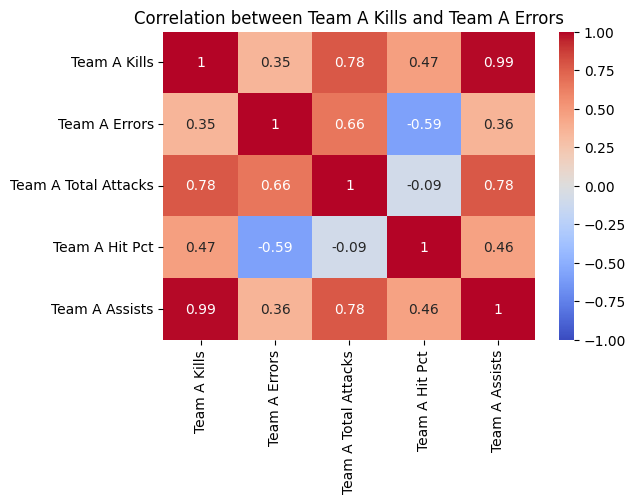

In [34]:
# Ataque
colunas_atq = [ 'Team A Kills',
       'Team A Errors', 'Team A Total Attacks', 'Team A Hit Pct',
       'Team A Assists']
df_atq = df_norm_clean[colunas_atq]

correlation_matrix = df_atq.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Kills and Team A Errors')
plt.show()

In [40]:
df_atq = df_atq.drop(columns=['Team A Assists'])

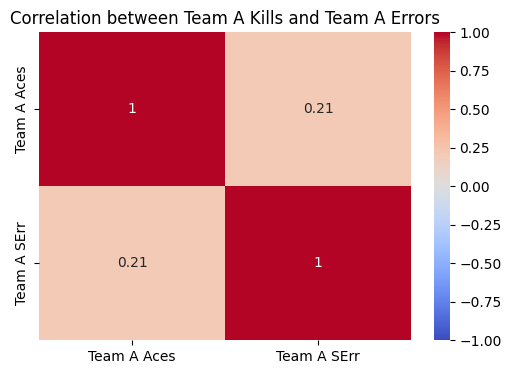

In [35]:
colunas_saq = ['Team A Aces', 'Team A SErr']
df_saq = df_norm_clean[colunas_saq]

correlation_matrix = df_saq.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Kills and Team A Errors')
plt.show()

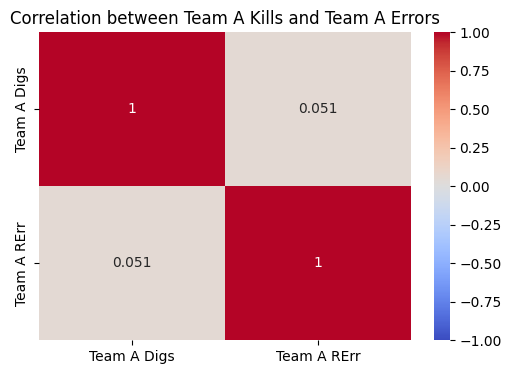

In [36]:
colunas_def = ['Team A Digs', 'Team A RErr']
df_def = df_norm_clean [colunas_def]

correlation_matrix = df_def.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Kills and Team A Errors')
plt.show()

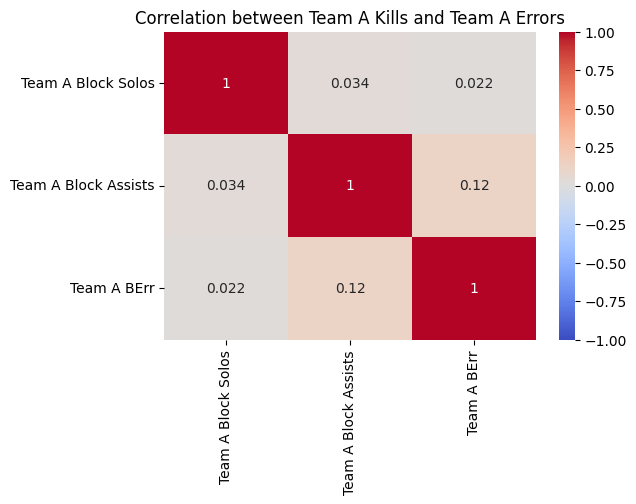

In [37]:
colunas_bloq = ['Team A Block Solos', 'Team A Block Assists', 'Team A BErr']
df_bloq = df_norm_clean [colunas_bloq]

correlation_matrix = df_bloq.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Team A Kills and Team A Errors')
plt.show()

In [41]:
df_atq.head()

,Team A Kills,Team A Errors,Team A Total Attacks,Team A Hit Pct
2,0.425287,0.357143,0.283981,0.427119
3,0.574713,0.482143,0.398058,0.421469
4,0.344828,0.303571,0.271845,0.394350
5,0.666667,0.392857,0.407767,0.505085
6,0.655172,0.303571,0.313107,0.613559


In [ ]:
df_saq.head()

,Team A Aces,Team A SErr
2,0.10,0.153846
3,0.45,0.230769
4,0.10,0.230769
5,0.30,0.230769
6,0.15,0.384615


In [ ]:
df_def.head()

,Team A Digs,Team A RErr
2,0.313725,0.20
3,0.496732,0.55
4,0.274510,0.15
5,0.418301,0.40
6,0.352941,0.40


In [ ]:
df_bloq.head()

,Team A Block Solos,Team A Block Assists,Team A BErr
2,0.2500,0.042553,0.111111
3,0.1250,0.425532,0.000000
4,0.0000,0.255319,0.000000
5,0.0625,0.276596,0.055556
6,0.0000,0.425532,0.000000


### **Teste Preliminar: KMeans**
Testei inicialmente, fazer semelhante ao que fizeram no artigo de base de rodas os testes do kmenas com n até no máximo o valor total de features daquela categoria. Mas os resultados deram péssimos, então testei 10 clusters só por desencargo de consciência

In [50]:
def kmeans_categoria(df):
    range_n_clusters = range(2,10)
    silhouette = []
    davies_bouldin = []

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters = n_clusters, n_init = 100 ,random_state = 42)
        kmeans.fit(df)
        labels = kmeans.labels_
        silhouette.append((n_clusters,silhouette_score(df, labels)))
        davies_bouldin.append((n_clusters,davies_bouldin_score(df,labels)))

    return davies_bouldin, silhouette

#### **KMeans para Ataque**

In [51]:
db_atq, sl_atq = kmeans_categoria(df_atq)
atq = {'Categoria': 'Ataque','Silhouette-Score':sl_atq,'Davies-Bouldin-Score':db_atq}
atq

{'Categoria': 'Ataque',
 'Silhouette-Score': [(2, 0.3740715159243375),
  (3, 0.4062319581517591),
  (4, 0.3556631885651738),
  (5, 0.3344601972833652),
  (6, 0.3177780203601323),
  (7, 0.2925306052909411),
  (8, 0.28259982666480965),
  (9, 0.28736151627793577)],
 'Davies-Bouldin-Score': [(2, 1.0593021844811792),
  (3, 0.8306998683313499),
  (4, 0.9936289711350664),
  (5, 0.9584824759363523),
  (6, 0.9615481027500462),
  (7, 1.017413160765051),
  (8, 1.0382349337226),
  (9, 0.9818758314890199)]}

#### **KMeans para Bloqueio**

In [52]:
db_bloq, sl_bloq = kmeans_categoria(df_bloq)
bloq = {'Categoria': 'Bloqueio','Silhouette-Score':sl_bloq,'Davies-Bouldin-Score':db_bloq}
bloq


{'Categoria': 'Bloqueio',
 'Silhouette-Score': [(2, 0.33521116886471736),
  (3, 0.2946463001765076),
  (4, 0.26217118088028685),
  (5, 0.2783766023432965),
  (6, 0.2822949460837904),
  (7, 0.25569592716399575),
  (8, 0.26327671625566823),
  (9, 0.25648825887859183)],
 'Davies-Bouldin-Score': [(2, 1.1790229115716555),
  (3, 1.2542246227410503),
  (4, 1.212043238941088),
  (5, 1.0515495620867403),
  (6, 1.067421629207177),
  (7, 1.132448123623471),
  (8, 1.0885420895141884),
  (9, 1.0834506455286388)]}

#### **KMeans para Defesa**

In [53]:
db_def, sl_def = kmeans_categoria(df_def)
de = {'Categoria': 'Defesa','Silhouette-Score':sl_def,'Davies-Bouldin-Score':db_def}
de

{'Categoria': 'Defesa',
 'Silhouette-Score': [(2, 0.36471332883871177),
  (3, 0.37925510830337866),
  (4, 0.3593227517409221),
  (5, 0.348995138658751),
  (6, 0.34004646166854535),
  (7, 0.33605277878140205),
  (8, 0.33770284048363647),
  (9, 0.3392483849472039)],
 'Davies-Bouldin-Score': [(2, 1.11305843042436),
  (3, 0.9020855268622551),
  (4, 0.9256520432461198),
  (5, 0.8918718936435199),
  (6, 0.8541594949599222),
  (7, 0.853691312223533),
  (8, 0.855556954645088),
  (9, 0.8389719162828357)]}

#### **KMeans para Saque**

In [54]:
db_saq, sl_saq = kmeans_categoria(df_saq)
saq = {'Categoria': 'Saque','Silhouette-Score':sl_saq,'Davies-Bouldin-Score':db_saq}
saq

{'Categoria': 'Saque',
 'Silhouette-Score': [(2, 0.3695654010803219),
  (3, 0.3675171621708919),
  (4, 0.3559336728373683),
  (5, 0.33755786938503857),
  (6, 0.33867354752014334),
  (7, 0.34578668342429775),
  (8, 0.3435240858734109),
  (9, 0.3462087771865997)],
 'Davies-Bouldin-Score': [(2, 1.0806432660659742),
  (3, 0.9603182855928649),
  (4, 0.90143513859783),
  (5, 0.8874125191593963),
  (6, 0.8909101342457202),
  (7, 0.8628110782296984),
  (8, 0.8648795058539153),
  (9, 0.8544815864566944)]}

#### **Análise de Resultados**

In [55]:
dados = []
casos = [saq,de,atq,bloq]

for caso in casos:
    for sl_tupla, db_tupla in zip(caso['Silhouette-Score'], caso['Davies-Bouldin-Score']):
        n_clusters = sl_tupla[0]
        sl_score = sl_tupla[1]
        db_score = db_tupla[1]
        

        dados.append({
            'Categoria': caso['Categoria'],
            'n clusters': n_clusters,
            'Silhouette Score': sl_score,
            'Davies-Bouldin Score': db_score
        })
resultados = pd.DataFrame(dados)

resultados

,Categoria,n clusters,Silhouette Score,Davies-Bouldin Score
0,Saque,2,0.369565,1.080643
1,Saque,3,0.367517,0.960318
2,Saque,4,0.355934,0.901435
3,Saque,5,0.337558,0.887413
4,Saque,6,0.338674,0.890910
5,Saque,7,0.345787,0.862811
6,Saque,8,0.343524,0.864880
7,Saque,9,0.346209,0.854482
8,Defesa,2,0.364713,1.113058
9,Defesa,3,0.379255,0.902086


### **Visualização Gráfica**

#### **Gráfico ataque**
o que apresentou o melhor db foi para 3 clusters

C:\Users\gabri\AppData\Local\Temp\ipykernel_16100\536883326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atq_cluster['Cluster'] = kmeans.fit_predict(df_atq_cluster[['Team A Kills', 'Team A Errors']])


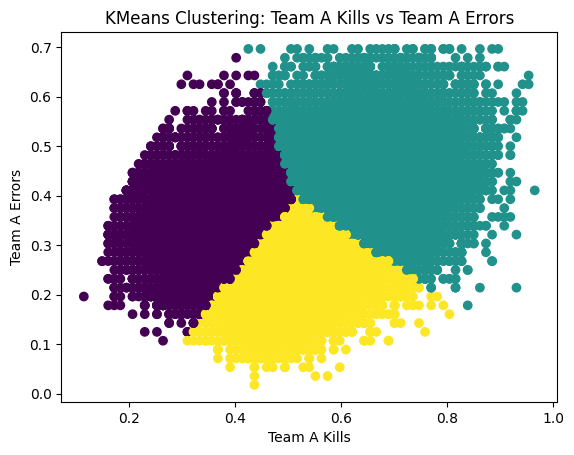

In [32]:
df_atq_cluster_atq_cluster = df_atq
kmeans = KMeans(n_clusters=3)
df_atq_cluster['Cluster'] = kmeans.fit_predict(df_atq_cluster[['Team A Kills', 'Team A Errors']])

plt.scatter(df_atq_cluster['Team A Kills'], df_atq_cluster['Team A Errors'], c=df_atq_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Kills')
plt.ylabel('Team A Errors')
plt.title('KMeans Clustering: Team A Kills vs Team A Errors')
plt.show()

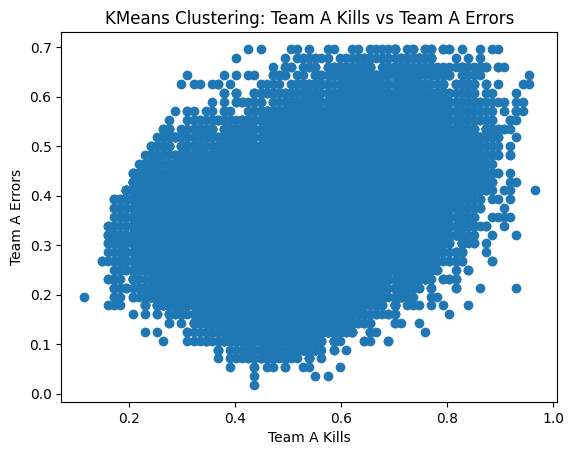

In [33]:
plt.scatter(df_atq_cluster['Team A Kills'], df_atq_cluster['Team A Errors'])
plt.xlabel('Team A Kills')
plt.ylabel('Team A Errors')
plt.title('KMeans Clustering: Team A Kills vs Team A Errors')
plt.show()

#### **Gráfico Bloqueio**
o melhor db foi para 5 clusters

C:\Users\gabri\AppData\Local\Temp\ipykernel_16100\894683170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bloq_cluster['Cluster'] = kmeans.fit_predict(df_bloq_cluster[['Team A Block Assists', 'Team A BErr']])


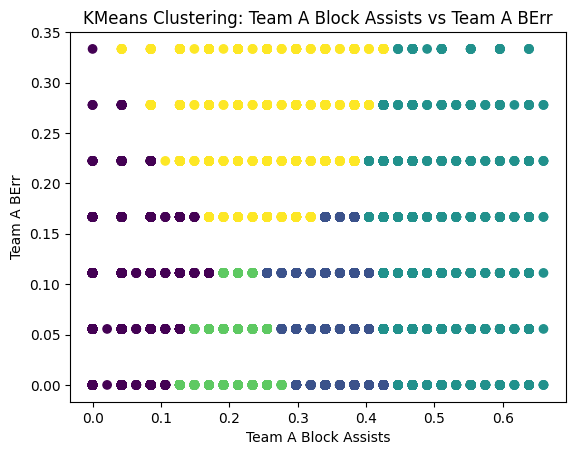

In [56]:
df_bloq_cluster = df_bloq
kmeans = KMeans(n_clusters=5)
df_bloq_cluster['Cluster'] = kmeans.fit_predict(df_bloq_cluster[['Team A Block Assists', 'Team A BErr']])

plt.scatter(df_bloq_cluster['Team A Block Assists'], df_bloq_cluster['Team A BErr'], c=df_bloq_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Block Assists')
plt.ylabel('Team A BErr')
plt.title('KMeans Clustering: Team A Block Assists vs Team A BErr')
plt.show()

#### **Gráfico Defesa**
db = 2

C:\Users\gabri\AppData\Local\Temp\ipykernel_16100\123583818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_def_cluster['Cluster'] = kmeans.fit_predict(df_def_cluster[['Team A Digs', 'Team A RErr']])


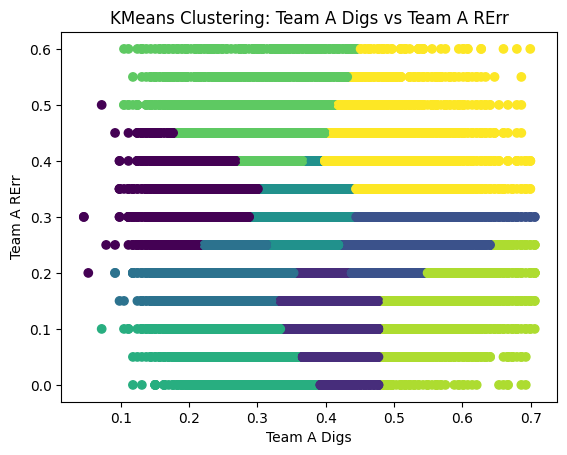

In [57]:
df_def_cluster = df_def
kmeans = KMeans(n_clusters=9)
df_def_cluster['Cluster'] = kmeans.fit_predict(df_def_cluster[['Team A Digs', 'Team A RErr']])

plt.scatter(df_def_cluster['Team A Digs'], df_def_cluster['Team A RErr'], c=df_def_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Digs')
plt.ylabel('Team A RErr')
plt.title('KMeans Clustering: Team A Digs vs Team A RErr')
plt.show()

#### **Gráfico Saque**
db = 2

C:\Users\gabri\AppData\Local\Temp\ipykernel_16100\1834040620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saq_cluster['Cluster'] = kmeans.fit_predict(df_saq_cluster[['Team A Aces', 'Team A SErr']])


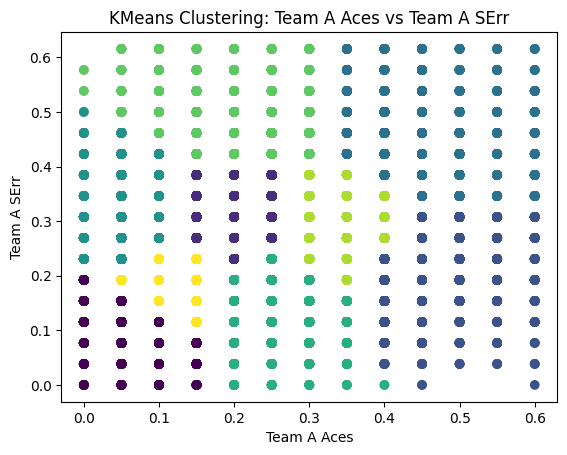

In [58]:
df_saq_cluster = df_saq
kmeans = KMeans(n_clusters=9)
df_saq_cluster['Cluster'] = kmeans.fit_predict(df_saq_cluster[['Team A Aces', 'Team A SErr']])

plt.scatter(df_saq_cluster['Team A Aces'], df_saq_cluster['Team A SErr'], c=df_saq_cluster['Cluster'], cmap='viridis')
plt.xlabel('Team A Aces')
plt.ylabel('Team A SErr')
plt.title('KMeans Clustering: Team A Aces vs Team A SErr')
plt.show()

### **Conclusões**

Pra quem não sabe Davies Bouldin quanto menor melhor e silhouette quanto maior melhor. Ou seja, resultados de merda 👍